In [7]:
# !pip install numpy pandas xarray xskillscore
# !pip install cdsapi
# !pip install matplotlib cartopy
# !pip install cfgrib
# !pip install ipywidgets

In [8]:
import os

import calendar

import xarray as xr

import ipywidgets as widgets

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

import cartopy.feature as cfeature

import numpy as np

# widgets.IntSlider()

# %matplotlib widget



# Configure the path and settings

SCOREDIR = "/kaggle/input/scores"

config = dict(

    list_vars = ['2m_temperature', ],

    hcstarty = 1993,

    hcendy = 2016,

    start_month = 11,

)



details="_1993-2016_monthly_mean_11_234_45_-30_-2.5_60"



available_files=["ukmo_602","meteo_france_8","ecmwf_51","eccc_3","eccc_2","dwd_21","cmcc_35"]





VARNAMES = {'t2m': '2-metre temperature'}

A-DETERLINISTIC

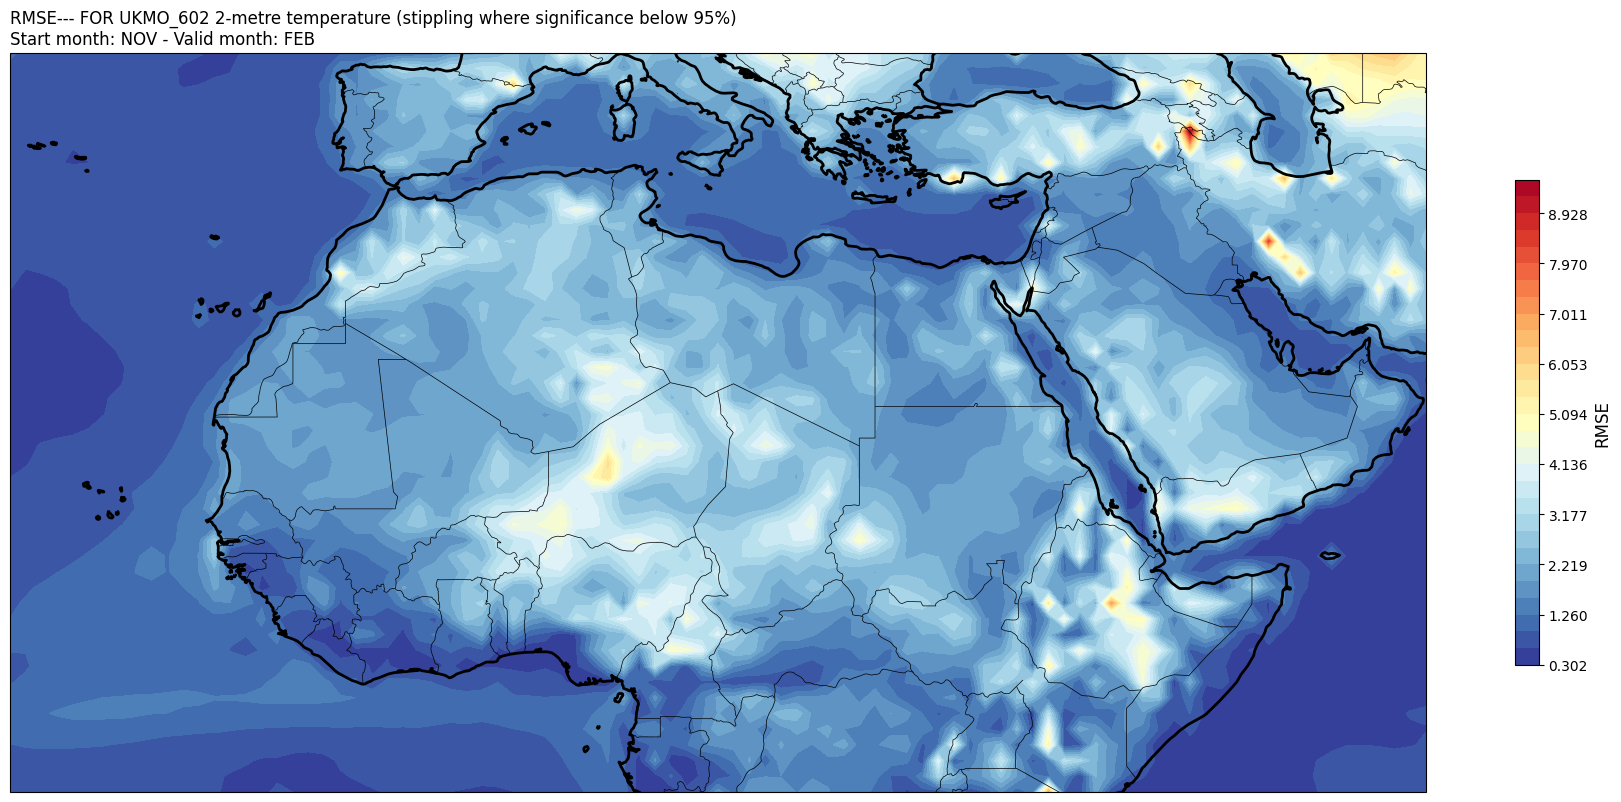

In [9]:


# Create dropdown widget for file selection

file_dropdown = widgets.Dropdown(

    options=available_files,

    description='CENTER'

)



# Load the datasets based on selected file and aggregation

def load_data(file_name, aggr,metric):

    file_link=f'{SCOREDIR}/{file_name}{details}.{aggr}.{metric}.nc'

    corr = xr.open_dataset(file_link)

    corr = corr.assign_coords(lon=(((corr.lon + 180) % 360) - 180)).sortby('lon')

    return corr

# Define the plot function

metrics=["corr","rsquared","rmse"]

def plot_corr(file_name, aggr, fcmonth,metric):

    origin_labels = {'institution': f'{file_name}'

                     ,'metric':f'{metric}'}

    METR = load_data(file_name, aggr,metric)

    tit_line1='{metric}---'.format(**origin_labels).upper()+" FOR "+file_name.upper()        

    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

    if aggr == '1m':

        validmonth = config['start_month'] + (fcmonth - 1)

        validmonth = validmonth if validmonth <= 12 else validmonth - 12

        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

    elif aggr == '3m':

        validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]

        tit_line2 = tit_line2_base + f' - Valid months: {" ".join(reversed(validmonths))}'

    else:

        raise ValueError(f'Unexpected aggregation {aggr}')



    # Select data for the chosen forecast month

    THISMETR = METR.sel(forecastMonth=fcmonth)



    for var in THISMETR.data_vars:

        fig = plt.figure(figsize=(18, 10))

        ax = plt.axes(projection=ccrs.PlateCarree())

        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)

        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.0)

        METRVALUES = THISMETR[var].values



        if METRVALUES.T.shape == (THISMETR[var].lat.size, THISMETR[var].lon.size):

            METRVALUES = METRVALUES.T



        plt.contourf(

            THISMETR[var].lon, THISMETR[var].lat, METRVALUES,

            levels=np.linspace(np.nanmin(METRVALUES), np.nanmax(METRVALUES), 30),

            cmap='RdYlBu_r'

        )

        cb = plt.colorbar(shrink=0.5)

        cb.ax.set_ylabel(metric.upper(), fontsize=12)

        origylim = ax.get_ylim()

        if ax.get_ylim() != origylim:

            ax.set_ylim(origylim)



        plt.title(f"{tit_line1} {VARNAMES[var]} (stippling where significance below 95%)\n{tit_line2}", loc='left')

        plt.tight_layout()

        plt.show()



# Create interactive widgets for `aggr`, `fcmonth`, and file selection

aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')

fcmonth_slider = widgets.IntSlider(value=4, min=2, max=4, step=1, description='Forecast Month:')

metric_droptown=widgets.Dropdown(options=metrics,value="rmse",description="Metric")

# Display the interactive plot

widgets.interactive(plot_corr, metric=metric_droptown,file_name=file_dropdown, aggr=aggr_dropdown, fcmonth=fcmonth_slider)

# B-PROBABILISTIC

In [10]:
VARNAMES = {
    't2m' : '2-metre temperature'
}
details="_1993-2016_monthly_mean_11_234_45_-30_-2.5_60"

available_files=["ukmo_602","meteo_france_8","ecmwf_51","eccc_3","eccc_2","dwd_21","cmcc_35"]

CATNAMES=['lower tercile', 'middle tercile', 'upper tercile']

# Change titles font size
plt.rc('axes', titlesize=20)

## B-1 RPS

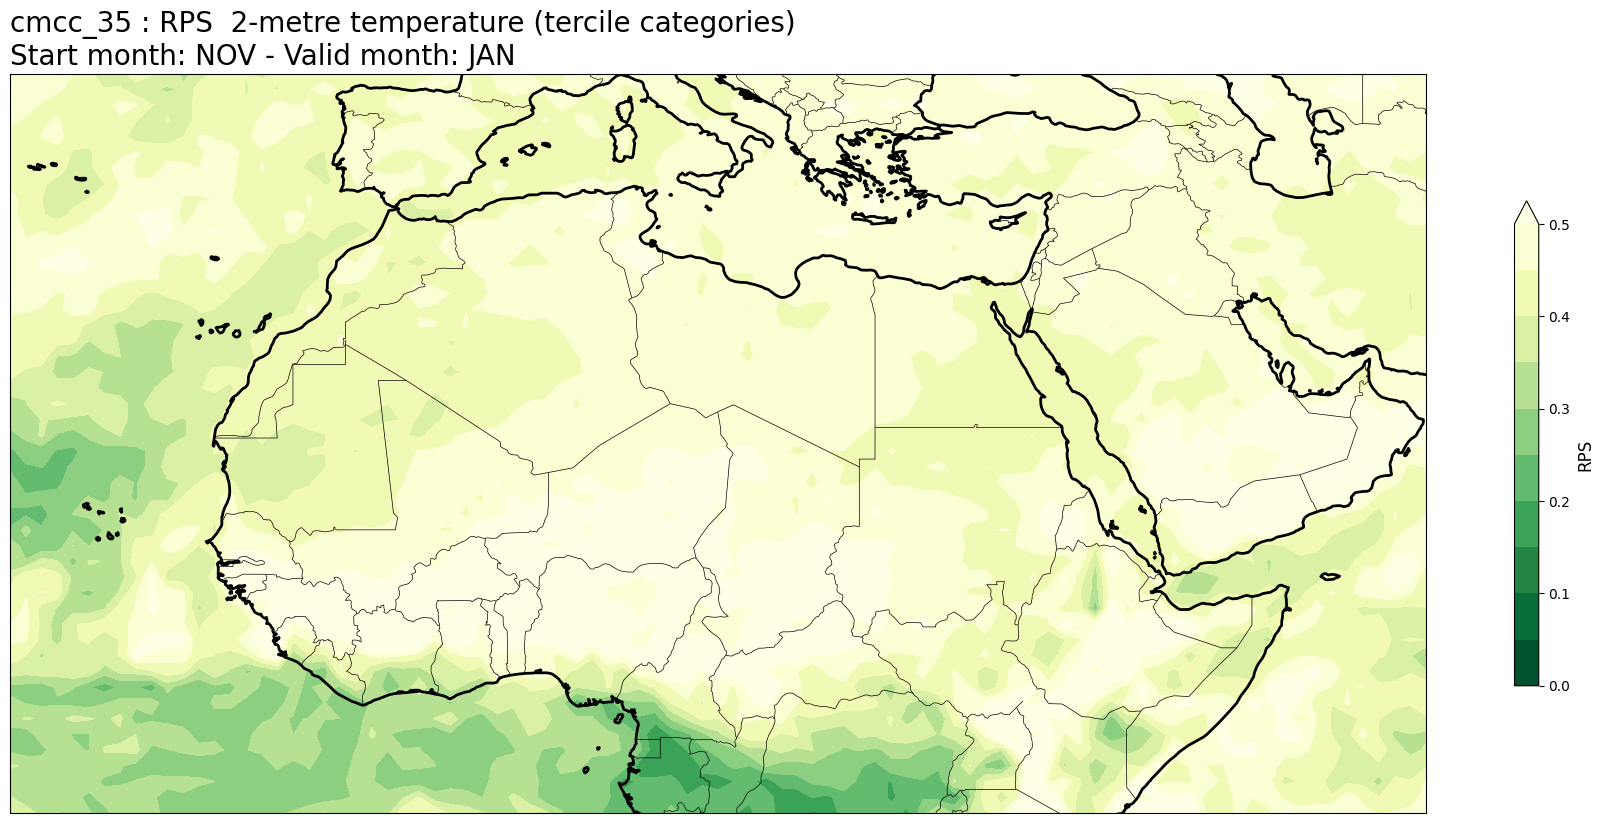

In [11]:
def load_data(file,aggr,metric):
    rps = xr.open_dataset(f'{SCOREDIR}/{file}{details}.{aggr}.{metric}.nc')
    return rps

# Define the plot function
def plot_corr(file,aggr, fcmonth):
    origin_labels = {'institution': f'{file}',
                    'SCORE':"RPS"}
    
    tit_line1 = '{institution} : {SCORE} '.format(**origin_labels)
    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'
    
    if aggr=='1m':
        validmonth = config['start_month'] + (fcmonth-1)
        validmonth = validmonth if validmonth<=12 else validmonth-12
    #     tit_line2 = tit_line2_base + rf' - Valid month: $\bf{calendar.month_abbr[validmonth].upper()}$'
        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'
    elif aggr=='3m':
        validmonths = [vm if vm<=12 else vm-12 for vm in [config['start_month'] + (fcmonth-1) - shift for shift in range(3)]]
        validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]
    #     tit_line2 = tit_line2_base + rf' - Valid months: $\bf{"".join(validmonths)}$'
        tit_line2 = tit_line2_base + f' - Valid months: {"".join(validmonths)}'
    else:
        raise BaseException(f'Unexpected aggregation {aggr}')
    rps = load_data(file,aggr,"rps")
    
    # Select data for the chosen forecast month
    thisrps = rps.sel(forecastMonth=fcmonth)
    for var in thisrps.data_vars:
        fig = plt.figure(figsize=(18,10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
        avalues = thisrps[var].values
        cs = plt.contourf(thisrps[var].lon,thisrps[var].lat,avalues,levels=np.linspace(0.,0.5,11),cmap='YlGn_r', extend='max')
        cs.cmap.set_under('purple')
        cb = plt.colorbar(shrink=0.5)
        cb.ax.set_ylabel('RPS',fontsize=12)
        plt.title(tit_line1 + f' {VARNAMES[var]}' + ' (tercile categories)\n' + tit_line2,loc='left')
        plt.tight_layout()  
        plt.show()


# Create interactive widgets for `aggr` and `fcmonth`
aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')
fcmonth_slider = widgets.IntSlider(value=3, min=2, max=4, step=1, description='Forecast Month:')
file_droptown=widgets.Dropdown(options=available_files,value="cmcc_35",description="Center")
widgets.interactive(plot_corr, file=file_droptown,aggr=aggr_dropdown, fcmonth=fcmonth_slider)

## B-2 ROC-ROCSS-BS

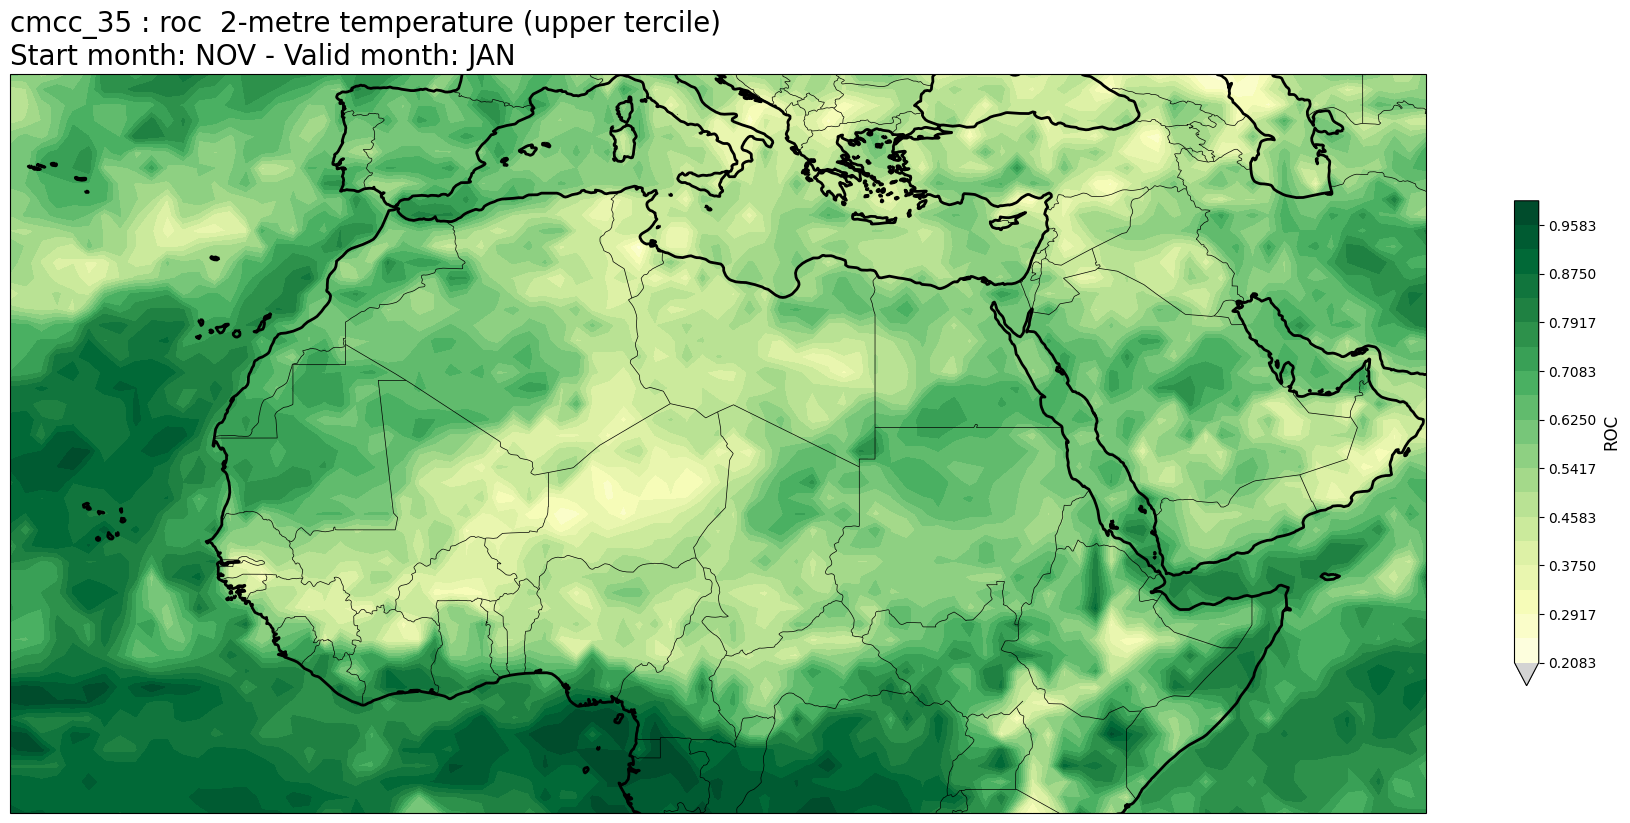

In [14]:
def load_data(file,aggr,metric):
    rps = xr.open_dataset(f'{SCOREDIR}/{file}{details}.{aggr}.{metric}.nc')
    return rps



def plot_roc(file,aggr,fcmonth,icat,metric):
    origin_labels = {'institution': f'{file}',
                    'SCORE':metric}
    
    tit_line1 = '{institution} : {SCORE} '.format(**origin_labels)
    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'
    
    if aggr=='1m':
        validmonth = config['start_month'] + (fcmonth-1)
        validmonth = validmonth if validmonth<=12 else validmonth-12
    #     tit_line2 = tit_line2_base + rf' - Valid month: $\bf{calendar.month_abbr[validmonth].upper()}$'
        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'
    elif aggr=='3m':
        validmonths = [vm if vm<=12 else vm-12 for vm in [config['start_month'] + (fcmonth-1) - shift for shift in range(3)]]
        validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]
    #     tit_line2 = tit_line2_base + rf' - Valid months: $\bf{"".join(validmonths)}$'
        tit_line2 = tit_line2_base + f' - Valid months: {"".join(validmonths)}'
    else:
        raise BaseException(f'Unexpected aggregation {aggr}')
    
    roc=load_data(file,aggr,metric)
    thisroc = roc.sel(forecastMonth=fcmonth)
    for var in thisroc.data_vars:
        fig = plt.figure(figsize=(18,10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
        avalues = thisroc.sel(category=icat)[var].values
        cs = plt.contourf(thisroc[var].lon,thisroc[var].lat,avalues,levels=np.linspace(np.nanmin(avalues), np.nanmax(avalues), 20),cmap='YlGn', extend='min')
        cs.cmap.set_under('lightgray')
        cb = plt.colorbar(shrink=0.5)
        cb.ax.set_ylabel(metric.upper(),fontsize=12)
        plt.title(tit_line1 + f' {VARNAMES[var]}' + f' ({CATNAMES[icat]})\n' + tit_line2, loc='left')
        plt.tight_layout()  
        plt.show()

file_droptown=widgets.Dropdown(options=available_files,value="cmcc_35",description="Center")
cat_slider=widgets.IntSlider(value=3,min=0,max=2,step=1,description="cat")
fcmonth_slider=widgets.IntSlider(value=3,min=2,max=4,step=1,description="fcmonth")
aggr_droptown=widgets.Dropdown(options=["1m","3m"],value="1m",description="aggr")
metric_dropdown=widgets.Dropdown(options=["roc","rocss","bs"],value="roc",description="Metric")
widgets.interactive(plot_roc,metric=metric_dropdown,file=file_droptown,aggr=aggr_droptown,fcmonth=fcmonth_slider,icat=cat_slider)